In [1]:
#imports
from bs4 import BeautifulSoup
from urllib.request import urlopen
import urllib
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

header = {'User-Agent': 'Mozilla/5.0'}

In [2]:
#get Gal Gadot films table
def part1(site):
    req = urllib.request.Request(site, headers=header)
    page = urlopen(req)
    soup = BeautifulSoup(page, 'lxml')

    table = soup.find_all('table')[1]

    tmp = table.find_all('tr')

    first = tmp[0]
    allRows = tmp[1:-1]

    headers = [header.get_text() for header in first.find_all('th')]

    results = [[data.get_text() for data in row.find_all('td')] for row in allRows]

    rowspan = []

    for no, tr in enumerate(allRows):
        tmp = []
        for td_no, data in enumerate(tr.find_all('td')):
            if data.has_attr("rowspan"):
                rowspan.append((no, td_no, int(data["rowspan"]), data.get_text()))

    if rowspan:
        for i in rowspan:
            for j in range(1, i[2]):
                results[i[0] + j].insert(i[1], i[3])

    df = pd.DataFrame(data=results, columns=headers)
    del df['Notes\n']

    films = []
    run = table.find_all('i')

    for item in df["Title\n"]:
        for atags in run:
            try:
                if (atags.next.text + "\n" == item):
                    next_url = "https://en.wikipedia.org" + atags.next.attrs['href']
                    films.append(next_url)
                    break
            except:
                continue
    return df,films

In [3]:
#get actors details
def getActorsUrl(moviesArr):
    names = []
    briths = []
    countries = []
    awards=[]
    dict={}
    for x in range(len(moviesArr)):
        counter=0
        found = False

        page = urlopen(urllib.request.Request(moviesArr[x], headers=header))


        soup = BeautifulSoup(page, 'lxml')

        something = soup.find('span', {"id": "Cast"})
        if (something == None):
            something = soup.find('span', {"id": "Voice_cast"})

        x = something.findNext("ul")
        nTrTagLen = len(soup.find_all('table')[0].find_all('tr'))

        for elem in x.findAll('li'):

            data = elem.findAll('a')
            if (len(data) > 0):
                data = data[0]
                counter+=1
                if (data.parent.text[:data.parent.text.index("as") - 1] not in names and data.parent.text[:data.parent.text.index("as") - 1] not in "Gal Gadot" ):
                    try:  # if the page of actor exsit
                        x1, x2 = getActorsInfo('https://en.wikipedia.org' + data.get('href'))
                        names += [getActorName('https://en.wikipedia.org' + data.get('href'))]
                        awards+=[getAwards('https://en.wikipedia.org' + data.get('href'),names[-1])]
                        dict.update({names[-1]:1})
                        briths += [x1]
                        countries += [x2]
                    except:  # if the page of actor doesnt exsit
                        True
                else:
                    if(data.parent.text[:data.parent.text.index("as") - 1] not in "Gal Gadot") :
                        dict[data.parent.text[:data.parent.text.index("as") - 1]]=dict[data.parent.text[:data.parent.text.index("as") - 1]]+1
                found = True


    df1 = pd.DataFrame({'names': names, 'Born year': briths, 'Born country': countries,'Num of awards':awards})
    return df1,dict



def getActorsInfo(actorWikiUrl):
    data_brith, data_country_brith = getBirthDate(actorWikiUrl)

    return data_brith, data_country_brith

def getActorName(actorWikiUrl):
    page = urlopen(urllib.request.Request(actorWikiUrl, headers=header))

    actorSoup = BeautifulSoup(page, 'lxml')



    return str(actorSoup.find("h1",{"id":"firstHeading"}).text)

def getBirthDate(actorWikiUrl):
    data_birthday = ''
    data_birthplace = ''
    birthday_found = False
    birthplace_found = False
    page = urlopen(urllib.request.Request(actorWikiUrl, headers=header))

    actorSoup = BeautifulSoup(page, 'lxml')

    for tableTb in range(len(actorSoup.find_all('table'))):
        if(not birthday_found):
            for tr in range(len(actorSoup.find_all('table')[tableTb].find_all('tr'))):
                bornTrTagText = actorSoup.find_all('table')[tableTb].find_all('tr')[tr].text
                if ('Born' in bornTrTagText):

                    match = re.search(r"\d{4}", bornTrTagText)
                    if match:
                        data_birthday = match.group(0)

                    try:
                        if (actorSoup.find_all('table')[tableTb].find_all('tr')[tr].find_all(class_='birthplace')[-1]):
                            data_birthplace = \
                            actorSoup.find_all('table')[tableTb].find_all('tr')[tr].find_all(class_='birthplace')[-1].text
                            try:
                                data_birthplace = re.split(",", data_birthplace, 0)
                                birthday_found=True
                            except:
                                data_birthplace=data_birthplace[-1]
                                birthday_found = True
                        else:

                            if(actorSoup.find_all('table')[tableTb].find_all('tr')[tr].find_all(class_='birthplace')[-1].find_all('a')):

                                data_birthplace = \
                                actorSoup.find_all('table')[tableTb].find_all('tr')[tr].find_all(class_='birthplace')[-1].find_all('a')[-1].text

                                try:
                                    data_birthplace = re.split(",", data_birthplace, 0)
                                    birthplace_found = True
                                except:
                                    data_birthplace = data_birthplace[-1]
                                    birthplace_found = True
                            birthday_found = True
                    except:
                        data_birthplace=actorSoup.find_all('table')[tableTb].find_all('tr')[tr].find_all('a')[-1].text
                        birthday_found = True
    if (data_birthday == ''):
        data_birthday = 'No birthday available'

    if ('list' in str(type(data_birthplace))):
        data_birthplace = data_birthplace[-1]

    if (data_birthplace == ''):
        data_birthplace = "No birthplace available"




    return data_birthday, data_birthplace

def getAwards(actorWikiUrl,name):
    try:
        page = urlopen(urllib.request.Request(actorWikiUrl, headers=header))
        actorSoup = BeautifulSoup(page, 'lxml')
        x=actorSoup.find("span",{"id":"Awards_and_nominations"})
        y=x.findNext("table",{"class":"wikitable sortable"})
        if(y==None):
            y = x.findNext("table", {"class": "wikitable"})
        if(y==None):
            y = x.findNext("table")
        return len(y.findAll("td",{"class":"yes table-yes2"}))
    except:
        try:
            actorSoup.find("a",{"title":"List of awards and nominations received by "+name})
            page = urlopen(urllib.request.Request('https://en.wikipedia.org'+actorSoup.get('href'), headers=header))
            actorSoup = BeautifulSoup(page, 'lxml')
            return len(actorSoup.findAll("td", {"class": "yes table-yes2"}))
        except:
            return "unKnown"

start
Gal Gadot's films


,Year,Title,Role,Director(s)
0,2009\n,Fast & Furious\n,Gisele Yashar\n,Justin Lin\n
1,2010\n,Date Night\n,Natanya\n,Shawn Levy\n
2,2010\n,Knight and Day\n,Naomi\n,James Mangold\n
3,2011\n,Fast Five\n,Gisele Yashar\n,Justin Lin\n
4,2013\n,Fast & Furious 6\n,Gisele Yashar\n,Justin Lin\n
5,2014\n,Kicking Out Shoshana\n,Mirit Ben Harush\n,Shay Kanot\n
6,2015\n,Furious 7\n,Gisele Yashar\n,James Wan\n
7,2016\n,Triple 9\n,Elena Vlaslov\n,John Hillcoat\n
8,2016\n,Batman v Superman: Dawn of Justice\n,Diana Prince / Wonder Woman\n,Zack Snyder\n
9,2016\n,Criminal\n,Jill Pope\n,Ariel Vromen\n


Co-Actors table


,names,Born year,Born country,Num of awards
0,Vin Diesel,1967,U.S.,9
1,Paul Walker,1973,U.S.,3
2,Michelle Rodriguez,1978,United States,7
3,Jordana Brewster,1980,Panama,1
4,John Ortiz,1969,U.S.,unKnown
5,Laz Alonso,1974,U.S.,unKnown
6,Jack Conley (actor),1958,U.S.,unKnown
7,Shea Whigham,1969,U.S.,unKnown
8,Tego Calderón,1972,U.S.,0
9,Don Omar,1978,U.S.,0


Histogram of frequency


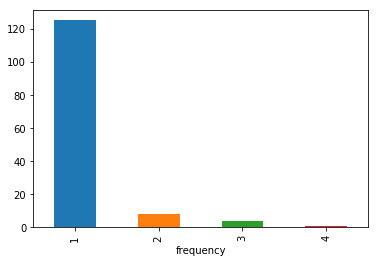

done


In [4]:
#main& and histogram plot
header = {'User-Agent': 'Mozilla/5.0'}
if __name__ == '__main__':
    print("start")
    site = "https://en.wikipedia.org/wiki/Gal_Gadot"
    df,films=part1(site)
    print("Gal Gadot's films")
    display(df)
    df1,dict=getActorsUrl(films)
    X = np.arange(len(dict))
    df2=pd.DataFrame.from_dict(data=dict,orient='index',columns=['frequency']).groupby(['frequency'])['frequency'].count()
    hist = df2.plot(kind="bar")
    print("Co-Actors table")
    display(df1)
    print("Histogram of frequency")
    plt.show()
    print("done")